In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

In [9]:
def split_image(img):
    im1 = img.crop((0, 0, 256, 256))
    im2 = img.crop((256, 0, 512, 256))
    return im1, im2

512 256


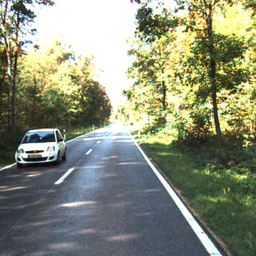

In [10]:
# finding out more about the images

image = Image.open("/kaggle/input/pix2pix-depth/pix2pix-depth/pix2pix-depth/testing/12752551.png")

imgwidth, imgheight = image.size

print(imgwidth, imgheight)

split_image(image)[0]

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, img_labels, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_labels = img_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        im = Image.open(img_path)
        image = np.array(split_image(im)[0])
        label = np.array(split_image(im)[1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [12]:
dir_path = "/kaggle/input/pix2pix-depth/pix2pix-depth/pix2pix-depth/testing"
# list to store files
res = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)

In [13]:
from torch.utils.data import DataLoader

training_data = CustomImageDataset(dir_path, res)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 256, 256, 3])
Labels batch shape: torch.Size([64, 256, 256, 3])


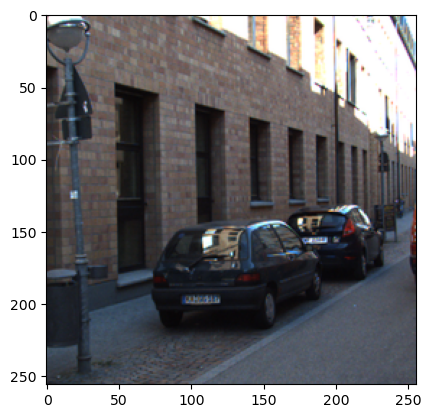

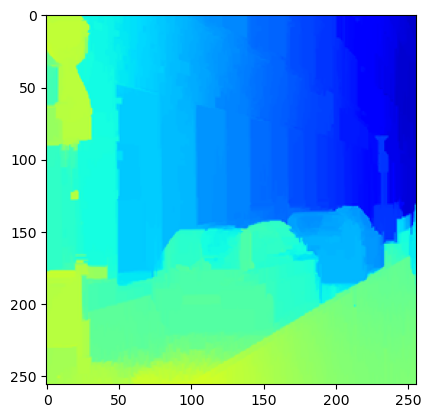

In [14]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0].squeeze()

plt.imshow(img, cmap="gray")
plt.show()

plt.imshow(label, cmap="gray")
plt.show()

In [38]:
training_data = CustomImageDataset(dir_path, res, ToTensor(), ToTensor())
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [39]:
#import pytorch dataloaders
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor, RandomHorizontalFlip, RandomRotation, RandomResizedCrop, ToPILImage
from torchvision.transforms.functional import pil_to_tensor, hflip, vflip, resize, normalize
from torchvision.io import read_image
from torch.utils.data import DataLoader

#import model dependencies
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import copy

In [40]:
transform = ToPILImage()

In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [42]:
class ConvModel(nn.Module):
    def __init__(self, img_w, img_h, batch_size, hidden_dim, classes):
        super(ConvModel, self).__init__()
        # Layers
        # In Shape = [batch_size, 3, img_w, img_h]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bnorm1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU() # 12 256 256
#         self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2)) 128*128

        img_w = int(img_w/2)
        img_h = int(img_h/2)

        # In Shape = [batch_size, 12, img_w/2, img_h/2]
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU() #20 256 256

        # In Shape = [batch_size, 20, img_w/2, img_h/2]
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU() #32 256 256

        # In Shape = [batch_size, 64, img_w/2, img_h/2]
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bnorm4 = nn.BatchNorm2d(num_features=64)
        self.relu4 = nn.ReLU() #64 256 256
#         self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2))  64*64

        img_w = int(img_w/2)
        img_h = int(img_h/2)

        # In Shape = [batch_size, 64, img_w/4, img_h/4]
        #flatten layer - Bridge
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1) #3 256 256

    def forward(self, x):
        x = self.conv1(x)
        x = self.bnorm1(x)
        x = self.relu1(x)
        
#         x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bnorm4(x)
        x = self.relu4(x)
#         x = self.maxpool4(x)

        logits = self.conv5(x)
    
        return logits

In [43]:
net = ConvModel(480, 640, 64, 512, 9)
print(net)

ConvModel(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [44]:
logits =[]
XR =[]
YR = []
for batch, (X, y) in enumerate(train_dataloader, 0):
    logits.append(net(X))
    XR.append(X)
    YR.append(y)
    break


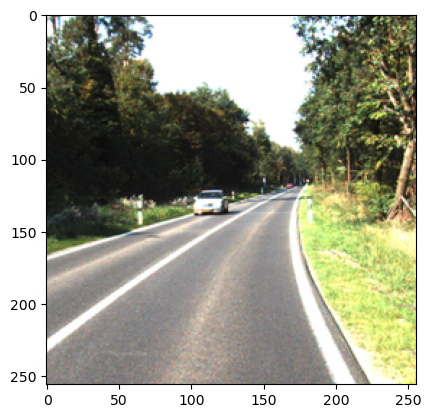

In [45]:
sample_in = XR[0][0]
# plt.imshow(sample_in.reshape(256,256))
# plt.show()
img = transform(sample_in)
plt.imshow(img)

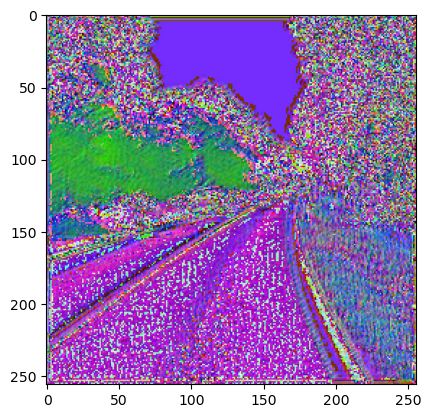

In [46]:
sample_out = logits[0][0]
img = transform(sample_out)
plt.imshow(img)

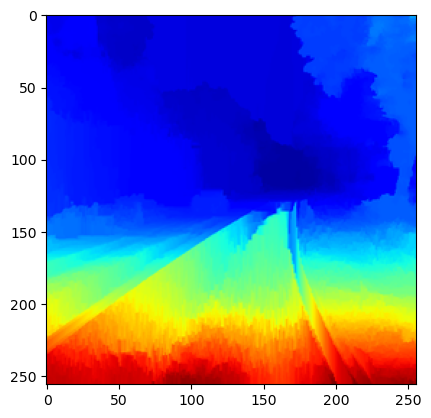

In [47]:
actual_out = YR[0][0]
img = transform(actual_out)
plt.imshow(img)

In [53]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.005, weight_decay = 0.0001)
epochs = 10

In [68]:
# Training step
for i in range(epochs):
    running_loss = 0.0
    net.train()
    for batch, (X, y) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        
        logits = net(X)
        
        criterion = loss_fn(logits, y)
        
        criterion.backward()
        
        optimizer.step()

        # print statistics
        running_loss += criterion.item()
        if batch % 10 == 0:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' % (i + 1, batch + 1, running_loss))
            running_loss = 0.0



[1,     1] loss: 0.590
[1,    11] loss: 3.397
[2,     1] loss: 0.165
[2,    11] loss: 1.643
[3,     1] loss: 0.153
[3,    11] loss: 1.439
[4,     1] loss: 0.142
[4,    11] loss: 1.371
[5,     1] loss: 0.125
[5,    11] loss: 1.328
[6,     1] loss: 0.127
[6,    11] loss: 1.373
[7,     1] loss: 0.138
[7,    11] loss: 1.331
[8,     1] loss: 0.157
[8,    11] loss: 1.292
[9,     1] loss: 0.129
[9,    11] loss: 1.316
[10,     1] loss: 0.149
[10,    11] loss: 1.299


#Test the model accuracy and loss till this point
size = len(tes.dataset)
num_batches = len(validation_dataloader)
net.eval()

test_loss, correct = 0, 0

with torch.no_grad():
    for X_test, y_test in validation_dataloader:
        pred = net(X_test)
        test_loss += loss_fn(pred, y_test).item()
        correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()

test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [71]:
torch.save(net.state_dict(), './model2.pth')

In [72]:
torch.save(net, './model2.pt')

In [73]:
import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile

model = torchvision.models.mobilenet_v2(pretrained=True)
model.eval()
example = torch.rand(1,3, 640, 480)
traced_script_module = torch.jit.trace(net, example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("./neural2.ptl")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
sample_input = torch.rand(1, 3, 640, 480)

In [59]:
torch.onnx.export(
    net,                  # PyTorch Model
    sample_input,                    # Input tensor
    "./model1.onxx",        # Output file (eg. 'output_model.onnx')
    opset_version=12,       # Operator support version
    input_names=['input'] ,  # Input tensor name (arbitary)
    output_names=['output'] # Output tensor name (arbitary)
)

In [60]:
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow
!pip install  ./onnx-tensorflow

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6516, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 6516 (delta 323), reused 380 (delta 259), pack-reused 6051
Receiving objects: 100% (6516/6516), 1.98 MiB | 6.68 MiB/s, done.
Resolving deltas: 100% (5050/5050), done.
Processing ./onnx-tensorflow
  Preparing metadata (setup.py) ... done
  Created wheel for onnx-tf: filename=onnx_tf-1.10.0-py3-none-any.whl size=226663 sha256=b56446536feb4487f651b3ffb525a49555f9359b15104a5e0d4b4870bd0da126
  Stored in directory: /root/.cache/pip/wheels/23/04/68/68c8dca4017a5998817850de95a49312b6c27d3add1d9a931e
Successfully built onnx-tf


In [66]:
import onnx

onnx_model = onnx.load("./model1.onxx")
from onnx_tf.backend import prepare

tf_rep = prepare(onnx_model)
tf_rep.export_graph("./tfmodel1.pb")


In [67]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("./tfmodel1.pb")
tflite_model = converter.convert()

# Save the model
with open("model1.tflite", 'wb') as f:
    f.write(tflite_model)